<a href="https://colab.research.google.com/github/EliasNoorzad/Pose6d_project/blob/main/models/tryModel_RGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading packages

In [ ]:
!pip install trimesh
!pip install --upgrade ipywidgets
!pip install ultralytics

  Using cached ultralytics-8.3.159-py3-none-any.whl.metadata (37 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

## Mounting to Google Drive

In [ ]:
import os
from google.colab import drive

# Define the base path for your Google Drive.
base_path = '/content/drive'

# Define the specific folder path within your Google Drive.
folder_path = 'path/to/project'

# Combine the base path and folder path to create the full mount path.
full_project_path = os.path.join(base_path, folder_path)

# Mount your drive.
drive.mount(base_path, force_remount=True)

Mounted at /content/drive


## Custom dataset

In [ ]:
import os
import yaml
import numpy as np
import json
import torch
import trimesh
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

class PoseEstimationDataset(Dataset):
    def __init__(self, dataset_root,
                 models_root,
                 folders=list(range(1, 16)),
                 split='train',
                 train_ratio=0.8,
                 seed=42,
                 img_size=(224, 224)):

        self.dataset_root = dataset_root
        self.models_root = models_root
        self.split = split
        self.train_ratio = train_ratio
        self.seed = seed
        self.img_size = img_size
        self.models = {}
        self.invalid_entries = 0

        self.models_info_path = os.path.join(models_root, 'models_info.yml')
        with open(self.models_info_path, 'r') as f:
            self.models_info = yaml.safe_load(f)

        # Cache gt.yml and info.yml per object
        self.gt_data = {}
        self.info_data = {}
        self.all_samples = []  # List of tuples: (object_id, sample_id)

        for obj_id in folders:
            obj_folder = os.path.join(dataset_root, f"{obj_id:02d}")
            gt_path = os.path.join(obj_folder, 'gt.yml')
            info_path = os.path.join(obj_folder, 'info.yml')

            if not os.path.exists(gt_path):
                continue

            with open(gt_path, 'r') as f:
                gt = yaml.safe_load(f)
            with open(info_path, 'r') as f:
                info = yaml.safe_load(f)

            self.gt_data[obj_id] = gt
            self.info_data[obj_id] = info

            for sample_id in gt.keys():
                self.all_samples.append((obj_id, int(sample_id)))

        # Get unique sorted object IDs
        object_id_set = set()
        for obj_id, sample_id in self.all_samples:
            annotations = self.gt_data[obj_id][sample_id]
            for ann in annotations:
                object_id_set.add(ann['obj_id'])
        self.object_ids = sorted(object_id_set)
        self.id_to_idx = {obj_id: i for i, obj_id in enumerate(self.object_ids)}
        self.idx_to_id = {i: obj_id for obj_id, i in self.id_to_idx.items()}

        if not self.all_samples:
            raise ValueError(f"No samples found in {dataset_root}. Check dataset structure.")

        # Split dataset
        train, test = train_test_split(self.all_samples, train_size=self.train_ratio, random_state=self.seed)
        self.samples = train if self.split == 'train' else test

        self.transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.samples)

    def save_mapping(self, filepath=None):
        if filepath is None:
            filepath = "object_id_mapping.json"
        with open(filepath, "w") as f:
            json.dump(self.id_to_idx, f)

    @staticmethod
    def load_mapping(filepath=None):
        if filepath is None:
            filepath = "object_id_mapping.json"
        with open(filepath, "r") as f:
            mapping = json.load(f)
        return {int(k): v for k, v in mapping.items()}

    def printIDMapping(self):
        print("Object ID Mapping (Original → Mapped):")
        for orig_id in self.object_ids:
            print(f"  {orig_id:02d} → {self.id_to_idx[orig_id]}")

    def nrInvalidObjects(self):
        return self.invalid_entries

    def getMappedIDs(self, ids=None): # If None it returns all.
        mapped_ids = []
        orig_ids = []
        if ids is None:
            for orig_id in self.object_ids:
                mapped_ids.append(self.id_to_idx[orig_id])
                orig_ids.append(orig_id)
        else:
            for id in ids:
                if id in self.id_to_idx:
                    mapped_ids.append(self.id_to_idx[id])
                    orig_ids.append(id)
                else:
                    #print(f"⚠️ Warning: Object ID {id} not found in dataset and will be ignored.")
                    pass
        return mapped_ids, orig_ids

    def get_model_info(self, object_id):
        if object_id not in self.models_info:
            raise ValueError(f"Object ID {object_id} not in models_info.yml")
        return self.models_info[object_id]

    def load_3D_model(self, object_id):
        if object_id in self.models:
            return self.models[object_id]

        model_path = os.path.join(self.models_root, f"obj_{object_id:02d}.ply")
        mesh = trimesh.load(model_path)
        points = mesh.vertices.astype(np.float32) / 1000.0  # Convert mm to meters
        self.models[object_id] = points
        return points

    def cropImages(self, image, annotations, cam_K):
        crop_entries = []
        width, height = image.size

        for ann in annotations:
            x, y, w, h = ann['obj_bb']
            x1 = max(0, x)
            y1 = max(0, y)
            x2 = min(width, x + w)
            y2 = min(height, y + h)

            # Filtering out entries with invalid boundry boxes.
            if x2 <= x1 or y2 <= y1:
                self.invalid_entries += 1
                continue

            cropped = image.crop((x1, y1, x2, y2))
            original_crop_width, original_crop_height = cropped.size

            cropped_K = cam_K.clone()
            cropped_K[0, 2] -= x1
            cropped_K[1, 2] -= y1

            cropped = cropped.resize(self.img_size, Image.BILINEAR)
            scale_x = self.img_size[0] / original_crop_width
            scale_y = self.img_size[1] / original_crop_height
            cropped_K[0, 0] *= scale_x
            cropped_K[0, 2] *= scale_x
            cropped_K[1, 1] *= scale_y
            cropped_K[1, 2] *= scale_y

            cropped_rgb_tensor = self.transform(cropped)
            R_mat = np.array(ann['cam_R_m2c'], dtype=np.float32).reshape(3, 3)
            t_vec = np.array(ann['cam_t_m2c'], dtype=np.float32) / 1000.0

            norm_bbox = torch.tensor([
                x1 / width,
                y1 / height,
                (x2 - x1) / width,
                (y2 - y1) / height
            ], dtype=torch.float32)

            crop_entries.append({
                'cropped_rgb': cropped_rgb_tensor,
                'cropped_K': cropped_K,
                'object_id': ann['obj_id'],
                'bbox': ann['obj_bb'],
                'norm_bbox': norm_bbox,
                'rotation': R_mat,
                'translation': t_vec
            })

        return crop_entries, cam_K

    def __getitem__(self, idx):
        object_id, sample_id = self.samples[idx]
        folder = os.path.join(self.dataset_root, f"{object_id:02d}")

        rgb_path = os.path.join(folder, 'rgb', f"{sample_id:04d}.png")
        if not os.path.exists(rgb_path):
            raise FileNotFoundError(f"RGB image not found: {rgb_path}")
        rgb = Image.open(rgb_path).convert("RGB")

        annotations = self.gt_data[object_id][sample_id]
        cam_K = torch.tensor(np.array(self.info_data[object_id][sample_id]['cam_K']).reshape(3, 3), dtype=torch.float32)

        crop_entries, org_K = self.cropImages(rgb, annotations, cam_K)

        # ✅ Fix: remap each entry's object_id correctly
        for entry in crop_entries:
            true_obj_id = entry['object_id']
            if true_obj_id not in self.id_to_idx:
                raise ValueError(f"Object ID {true_obj_id} not found in id_to_idx mapping.")
            entry['object_id'] = self.id_to_idx[true_obj_id]  # use actual mapping

        return {
            'sample_id': sample_id,
            'original_rgb': rgb,
            'original_K': org_K,
            'objects': crop_entries
        }

## PoseNet6D using ResNet18

In [ ]:
from torch import nn
import torch
import torch.nn.functional as F
# Loading the resnet18 model together with pre-trained weights.
from torchvision.models import resnet18, ResNet18_Weights


class PoseNet6D(nn.Module):
    """
    PoseNet6D estimates 6D object pose (translation and rotation) from cropped RGB images,
    using a CNN backbone (ResNet18), bounding box information, and object ID embeddings.
    """
    def __init__(self, num_objects,
                 embedding_dim=16,
                 img_size=(224, 224),
                 weights=ResNet18_Weights.DEFAULT):
        """
        Initializes the network components.

        Args:
            num_objects (int): Number of unique object classes.
            embedding_dim (int): Size of the object ID embedding vector.
            img_size (tuple): Size of the input images (width, height).
            weights (ResNet18_Weights): Pretrained weights for ResNet18 backbone.
        """
        super(PoseNet6D, self).__init__()
        self.img_size = img_size

        # Load pretrained ResNet18 and remove the last two layers (avgpool and FC).
        resnet = resnet18(weights=weights)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Output: (B, 512, 7, 7).

        # Global average pooling to reduce spatial features to vector.
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Object ID embedding layer.
        self.obj_embedding = nn.Embedding(num_embeddings=num_objects,
                                          embedding_dim=embedding_dim)

        # Concatenated feature size: image (512) + bbox (4) + object embedding.
        fused_dim = 512 + 4 + embedding_dim

        # Fully connected layers for depth estimation (1 output value).
        self.fc_depth = nn.Sequential(
            nn.Linear(fused_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

        # Fully connected layers for quaternion rotation (4D unit vector).
        self.fc_rotation = nn.Sequential(
            nn.Linear(fused_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 4)
        )

    def forward(self, x_img, norm_bbox, K_crop, object_id):
        """
        Forward pass to estimate translation and rotation.

        Args:
            x_img (Tensor): Input cropped RGB image (B, 3, H, W).
            norm_bbox (Tensor): Normalized bounding boxes (B, 4).
            K_crop (Tensor): Intrinsics matrix adjusted to crop (B, 3, 3).
            object_id (Tensor): Object class indices (B,).

        Returns:
            translation (Tensor): Estimated 3D translation vector (B, 3).
            quat (Tensor): Estimated rotation quaternion (B, 4).
        """
        B = x_img.shape[0]

        # CNN feature extraction.
        x = self.backbone(x_img)                # Shape: (B, 512, 7, 7)
        x = self.global_pool(x).view(B, -1)     # Shape: (B, 512)

        # Ensure object IDs are on the correct device.
        object_id = object_id.to(self.obj_embedding.weight.device)

        # Object embedding lookup.
        obj_feat = self.obj_embedding(object_id)  # Shape: (B, embedding_dim)

        # Concatenate image features, bbox, and object embedding.
        x = torch.cat([x, norm_bbox, obj_feat], dim=1)  # Shape: (B, fused_dim)

        # Predict object depth (z).
        depth = self.fc_depth(x).squeeze(1)  # Shape: (B,)
        depth = torch.clamp(depth, min=0.1, max=1.5)  # Clamp to avoid extreme values

        # Predict object orientation as a unit quaternion.
        quat = F.normalize(self.fc_rotation(x), dim=1)  # Shape: (B, 4)

        # Deproject normalized bbox center to camera coordinates using intrinsics.
        fx = K_crop[:, 0, 0]
        fy = K_crop[:, 1, 1]
        cx_crop = K_crop[:, 0, 2]
        cy_crop = K_crop[:, 1, 2]

        img_w, img_h = self.img_size
        u = (norm_bbox[:, 0] + 0.5 * norm_bbox[:, 2]) * img_w  # Center x
        v = (norm_bbox[:, 1] + 0.5 * norm_bbox[:, 3]) * img_h  # Center y

        # Back-project to 3D camera coordinates.
        x_cam = (u - cx_crop) * depth / fx
        y_cam = (v - cy_crop) * depth / fy
        z_cam = depth

        translation = torch.stack([x_cam, y_cam, z_cam], dim=1)  # Shape: (B, 3)
        return translation, quat

## Helper functions

In [ ]:
import torch.nn.functional as F
from scipy.spatial.transform import Rotation as R
from scipy.spatial import cKDTree

def computeADD(R_pred, t_pred, R_gt, t_gt, model_points):
    # Converting all inputs into NumPy.
    def to_np(x):
        return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else x
    R_pred, t_pred = to_np(R_pred), to_np(t_pred)
    R_gt, t_gt = to_np(R_gt), to_np(t_gt)
    model_points = to_np(model_points)

    # Transforming model points.
    pred_pts = model_points @ R_pred.T + t_pred
    gt_pts = model_points @ R_gt.T + t_gt

    # Returning ADD for the prediction.
    distances = np.linalg.norm(pred_pts - gt_pts, axis=1)
    return distances.mean()

def matrix_to_quaternion_batch(rotation_matrix):
    if rotation_matrix.dim() == 2:  # If it's a single 3x3 matrix
        rotation_matrix = rotation_matrix.unsqueeze(0)  # Add a batch dimension

    batch_size = rotation_matrix.size(0)
    quaternions = torch.zeros(batch_size, 4, device=rotation_matrix.device)

    # Compute trace and clamp for numerical safety
    trace = torch.diagonal(rotation_matrix, dim1=1, dim2=2).sum(dim=1)
    trace = torch.clamp(trace, min=-0.999)  # Prevent sqrt of negative

    s = torch.sqrt(1.0 + trace) / 2.0  # Safe sqrt
    quaternions[:, 0] = s

    # Prevent division by zero
    denom = 4.0 * s
    denom = torch.clamp(denom, min=1e-6)

    quaternions[:, 1] = (rotation_matrix[:, 2, 1] - rotation_matrix[:, 1, 2]) / denom
    quaternions[:, 2] = (rotation_matrix[:, 0, 2] - rotation_matrix[:, 2, 0]) / denom
    quaternions[:, 3] = (rotation_matrix[:, 1, 0] - rotation_matrix[:, 0, 1]) / denom

    # Normalize to ensure unit quaternion
    quaternions = F.normalize(quaternions, dim=1)

    return quaternions

def quaternion_to_matrix_batch(quat):
    # Adding the batch dimension if single quaternion.
    if quat.dim() == 1:
        quat = quat.unsqueeze(0)

    # Extracting the elements.
    w, x, y, z = quat[:, 0], quat[:, 1], quat[:, 2], quat[:, 3]

    B = quat.size(0) # Re-shaping.
    R = torch.zeros((B, 3, 3), device=quat.device)

    # Calculating elementswise.
    R[:, 0, 0] = 1 - 2 * (y**2 + z**2)
    R[:, 0, 1] = 2 * (x * y - z * w)
    R[:, 0, 2] = 2 * (x * z + y * w)
    R[:, 1, 0] = 2 * (x * y + z * w)
    R[:, 1, 1] = 1 - 2 * (x**2 + z**2)
    R[:, 1, 2] = 2 * (y * z - x * w)
    R[:, 2, 0] = 2 * (x * z - y * w)
    R[:, 2, 1] = 2 * (y * z + x * w)
    R[:, 2, 2] = 1 - 2 * (x**2 + y**2)

    if quat.dim() == 1:
        R = R.squeeze(0)  # Remove batch dimension if single quaternion.

    return R

def quaternion_loss(quat_pred, quat_gt):
    # Normalizing.
    quat_pred = F.normalize(quat_pred, dim=1)
    quat_gt = F.normalize(quat_gt, dim=1)
    dot = torch.sum(quat_pred * quat_gt, dim=1)
    # Clamping results to avoid unrealistic results.
    dot = torch.clamp(dot, -1.0 + 1e-4, 1.0 - 1e-4)
    loss = 1 - dot**2  # Minimizes angular difference.
    return loss.mean()

def quaternion_angular_error(q1, q2):
    dot = torch.sum(q1 * q2, dim=1).clamp(-1.0, 1.0)
    dot = torch.abs(dot)  # Handling the ±q ambiguity.
    angle = 2 * torch.acos(dot) * (180.0 / torch.pi)  # Radians → degrees.
    return angle

def computeMSE(rot_pred, t_pred, rot_gt, t_gt, quat=False,
               weight_xyz=(1.0, 1.0, 0.1), beta=1.0, print_mse=False):
    # Clamping predictions to avoid log(0).
    t_pred = torch.clamp(t_pred, min=1e-3)
    t_gt = torch.clamp(t_gt, min=1e-3)

    # Calculating weighted, per-axis translation loss.
    x_loss = F.mse_loss(t_pred[:, 0], t_gt[:, 0]) * weight_xyz[0]
    y_loss = F.mse_loss(t_pred[:, 1], t_gt[:, 1]) * weight_xyz[1]
    # Here we're using log to smooth out z-loss.
    z_loss = F.mse_loss(torch.log(t_pred[:, 2]), torch.log(t_gt[:, 2])) * weight_xyz[2]

    # Summing translational losses.
    translation_loss = x_loss + y_loss + z_loss

    # Calculating the rotational loss.
    if quat:
        rotation_loss = quaternion_loss(rot_pred, rot_gt)
    else:
        rot_diff = torch.bmm(rot_pred.transpose(1, 2), rot_gt)
        identity = torch.eye(3, device=rot_pred.device).unsqueeze(0).expand(rot_pred.size(0), -1, -1)
        rotation_loss = F.mse_loss(rot_diff, identity)

    total_loss = translation_loss + beta * rotation_loss

    # Printing results.
    if print_mse:
        print(f"\nX loss:           {x_loss:.6f}")
        print(f"Y loss:           {y_loss:.6f}")
        print(f"Z loss:           {z_loss:.6f}")
        print(f"Rotation loss:    {rotation_loss:.6f}")
        print(f"Total loss:       {total_loss:.6f}")
        if quat:
            angle_deg = quaternion_angular_error(rot_pred, rot_gt).mean().item()
            print(f"Angular error (deg): {angle_deg:.2f}")

    return total_loss

## Functions for plotting the results

In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# YOLO | LineMOD - mapping.
yolo2linemod = {
    "0": 1,
    "1": 2,
    "2": 4,
    "3": 5,
    "4": 6,
    "5": 8,
    "6": 9,
    "7": 10,
    "8": 11,
    "9": 12,
    "10": 13,
    "11": 14,
    "12": 15
    }

# === Drawing Utilities ===

def draw_model_projection(image, points, color, radius=1):
    for pt in points.astype(int):
        x, y = pt
        if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
            cv2.circle(image, (x, y), radius, color, -1)

def draw_bbox(image, bbox, color, label=None, thickness=2, dashed=False):
    x1, y1, x2, y2 = map(int, bbox)
    if dashed:
        # Draw dashed rectangle
        line_type = cv2.LINE_AA
        step = 5
        for i in range(x1, x2, step * 2):
            cv2.line(image, (i, y1), (min(i + step, x2), y1), color, thickness, line_type)
            cv2.line(image, (i, y2), (min(i + step, x2), y2), color, thickness, line_type)
        for i in range(y1, y2, step * 2):
            cv2.line(image, (x1, i), (x1, min(i + step, y2)), color, thickness, line_type)
            cv2.line(image, (x2, i), (x2, min(i + step, y2)), color, thickness, line_type)
    else:
        cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)

    if label:
        cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

def draw_legend(image, labels_colors):
    x, y, spacing = 10, 25, 25
    font_scale = 0.4
    text_thickness = 1
    box_width = 10
    box_height = 10
    for i, (label, color) in enumerate(labels_colors):
        text_y = y + i * spacing + box_height // 2
        cv2.putText(image, label, (x + box_width + 5, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, text_thickness)
        cv2.rectangle(image, (x, y - box_height//2 + i * spacing),
                             (x + box_width, y + box_height//2 + i * spacing), color, -1)

def draw_axes(image, R, t, K, is_gt=False, axis_length=0.05, thickness=2):
    axes_3d = np.array([[0, 0, 0],
                        [axis_length, 0, 0],
                        [0, axis_length, 0],
                        [0, 0, axis_length]], dtype=np.float32)
    pts_2d = (K @ (axes_3d @ R.T + t).T).T
    pts_2d = pts_2d[:, :2] / pts_2d[:, 2:3]
    pts_2d = pts_2d.astype(int)

    o = tuple(pts_2d[0])
    cv2.circle(image, o, 6, (255, 255, 255), -1)

    colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0)] if not is_gt else [(100, 100, 255), (100, 255, 100), (255, 100, 100)]
    for i in range(1, 4):
        cv2.line(image, o, tuple(pts_2d[i]), colors[i - 1], thickness)
    return image

def project(pts, R, t, K):
    proj = (K @ (pts @ R.T + t).T).T
    return proj[:, :2] / proj[:, 2:3]

# === YOLOv8 to PoseNet conversion ===
def prepare_posenet_input_from_yolo(yolo_result, class_idx, original_rgb, cam_K, dataset,
                                    input_size=(224, 224), conf_thresh=0.5):
    if not isinstance(original_rgb, np.ndarray):
        original_rgb = np.array(original_rgb)

    boxes = yolo_result[0].boxes

    for i in range(len(boxes)):
        conf = boxes.conf[i].item()
        detected_class = int(boxes.cls[i].item())

        #print(f"\n🧪 Box {i}: YOLO class {detected_class} ({yolo_model.names[detected_class]})")

        yolo_class_str = str(detected_class)
        linemod_id = yolo2linemod[yolo_class_str]
        #print(f"   → Mapped to LineMOD ID: {linemod_id}, requested LineMOD ID: {class_idx}")

        if linemod_id != class_idx:
            #print("   ❌ Skipped: LineMOD ID doesn't match requested class_idx")
            continue

        print(f"📦 YOLO returned {len(boxes)} boxes")
        print("✅ MATCH! This box will be used.")

        # Bounding box
        x_min, y_min, x_max, y_max = map(int, boxes.xyxy[i].tolist())
        H, W, _ = original_rgb.shape
        x_min, y_min = max(0, x_min), max(0, y_min)
        x_max, y_max = min(W, x_max), min(H, y_max)
        if x_max <= x_min or y_max <= y_min:
            continue

        # Crop image
        crop = original_rgb[y_min:y_max, x_min:x_max]
        original_crop_height, original_crop_width = crop.shape[:2]

        # Resize crop
        crop_resized = cv2.resize(crop, input_size).astype(np.float32) / 255.0
        crop_resized = (crop_resized - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
        rgb_tensor = torch.tensor(crop_resized, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

        # Scale intrinsics
        scale_x = input_size[0] / original_crop_width
        scale_y = input_size[1] / original_crop_height

        cropped_K = cam_K.copy()
        cropped_K[0, 2] -= x_min
        cropped_K[1, 2] -= y_min
        cropped_K[0, 0] *= scale_x
        cropped_K[0, 2] *= scale_x
        cropped_K[1, 1] *= scale_y
        cropped_K[1, 2] *= scale_y
        cropped_K_tensor = torch.tensor(cropped_K, dtype=torch.float32).unsqueeze(0)

        # Normalize bbox (x_min, y_min, x_max, y_max).
        norm_bbox = torch.tensor([[x_min / W, y_min / H, x_max / W, y_max / H]], dtype=torch.float32)

        # Object ID mapping.
        mapped_obj_id = dataset.id_to_idx[linemod_id]
        obj_tensor = torch.tensor([mapped_obj_id], dtype=torch.long)

        cls_name = yolo_model.names[detected_class]

        return {
            'cropped_rgb': rgb_tensor,
            'norm_bbox': norm_bbox,
            'cropped_K': cropped_K_tensor,
            'obj_tensor': obj_tensor,
            'bbox': [x_min, y_min, x_max, y_max],
            'original_obj_id': linemod_id,
            'mapped_obj_id': mapped_obj_id,
            'conf': conf,  # 🔥 add confidence
            'cls_name': cls_name  # 🔥 add class name
        }

    return None

# === Visualization ===
def visualize_pose_prediction(obj, model, dataset, obj_id, device,
                              draw_axes_flag=False, draw_models=True, draw_bboxes=False, use_full_frame=False,
                              save_prefix="result", legend=False, cam_K=None):

    # --- Prepare input tensors ---
    rgb = obj['cropped_rgb'].to(device).float()
    norm_bbox = obj['norm_bbox'].to(device).float()
    cropped_K = obj['cropped_K'].to(device).float()
    obj_tensor = obj['obj_tensor'].to(device)

    # Check if GT is available.
    R_gt_available = 'rotation' in obj and 'translation' in obj
    if R_gt_available:
        R_gt = obj['rotation']
        t_gt = obj['translation']
    else:
        R_gt = None
        t_gt = None
        quat_gt = None

    with torch.no_grad():
        t_pred, quat_pred = model(rgb, norm_bbox, cropped_K, obj_tensor)
        R_pred = quaternion_to_matrix_batch(quat_pred.detach()).squeeze().cpu().numpy()
        t_pred = t_pred.detach().squeeze().cpu().numpy()

        ang_err = None
        if R_gt_available:
            quat_gt = matrix_to_quaternion_batch(torch.tensor(R_gt, dtype=torch.float32).to(device))
            ang_err = quaternion_angular_error(quat_pred, quat_gt).item()

    original_id = dataset.idx_to_id[obj_id]
    model_points = dataset.load_3D_model(original_id)

    # --- Cropped View ---
    crop_rgb = rgb.squeeze().cpu().numpy().transpose(1, 2, 0)
    crop_rgb = ((crop_rgb * 0.229 + 0.485).clip(0, 1) * 255).astype(np.uint8)
    crop_rgb = cv2.cvtColor(crop_rgb, cv2.COLOR_RGB2BGR)
    cropped_K_np = cropped_K.squeeze().cpu().numpy()

    vis_crop = crop_rgb.copy()
    if draw_axes_flag:
        vis_crop = draw_axes(vis_crop, R_pred, t_pred, cropped_K_np)
        vis_crop = draw_axes(vis_crop, R_gt, t_gt, cropped_K_np, is_gt=True)
    if draw_models:
        draw_model_projection(vis_crop, project(model_points, R_gt, t_gt, cropped_K_np), (0, 255, 0))
        draw_model_projection(vis_crop, project(model_points, R_pred, t_pred, cropped_K_np), (0, 0, 255))
    if legend:
        draw_legend(vis_crop, [("GT", (0, 255, 0)), ("Pred", (0, 0, 255))])
    if draw_bboxes:
        label = f"{obj['cls_name']} ({obj['conf']:.2f})"
        draw_bbox(vis_crop, [0, 0, vis_crop.shape[1], vis_crop.shape[0]], color=(0, 0, 255), label=label)
        #draw_bbox(vis_crop, obj.get("bbox", []), color=(0, 0, 255), label="YOLO")
        #draw_bbox(vis_crop, obj.get("gt_bbox", []), color=(0, 255, 0), label="GT", dashed=True)

    # Print metrics only if GT is available.
    if R_gt_available:
        add = computeADD(R_pred, t_pred, R_gt, t_gt, model_points)
        print(f"\n➡️ Object {original_id} (mapped ID {obj_id})")
        print(f"ADD: {add:.4f} m | Angular Error: {ang_err:.2f}°")
    else:
        print(f"\n➡️ Object {original_id} (mapped ID {obj_id})")
        print("   (GT pose not available for this detection)")

    plt.figure()
    plt.imshow(cv2.cvtColor(vis_crop, cv2.COLOR_BGR2RGB))
    plt.title(f"[Cropped] Obj {original_id}")
    plt.axis("off")
    plt.show()

    # --- Full Frame View ---
    if use_full_frame:
        full_image = cv2.cvtColor(np.array(obj['original_rgb']), cv2.COLOR_RGB2BGR)

        # Draw Predicted elements on full frame.
        if draw_axes_flag:
            full_image = draw_axes(full_image, R_pred, t_pred, cam_K, is_gt=False)
        if draw_models:
            draw_model_projection(full_image, project(model_points, R_pred, t_pred, cam_K), (0, 0, 255))

        # Draw GT elements on full frame only if available.
        if R_gt_available:
            if draw_axes_flag:
                full_image = draw_axes(full_image, R_gt, t_gt, cam_K, is_gt=True)
            if draw_models:
                draw_model_projection(full_image, project(model_points, R_gt, t_gt, cam_K), (0, 255, 0))
            if legend:
                 # Show both Pred and GT in legend if both are drawn.
                 draw_legend(full_image, [("GT", (0, 255, 0)), ("Pred", (0, 0, 255))])
        elif legend:
             # Show only Pred in legend if GT is not drawn.
             draw_legend(full_image, [("Pred", (0, 0, 255))])

        if draw_bboxes:
             # Draw YOLO detection bbox on full frame.
             label = f"{obj['cls_name']} ({obj['conf']:.2f})"
             draw_bbox(full_image, obj['bbox'], color=(0, 0, 255), label=label) # Blue for YOLO/Pred Bbox.

             # Draw GT bbox if available on full frame
             if R_gt_available and 'gt_bbox' in obj:
                  draw_bbox(full_image, obj['gt_bbox'], color=(0, 255, 0), label="GT", dashed=True) # Green dashed for GT Bbox.

        plt.figure()
        plt.imshow(cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB))
        plt.title(f"[Full Frame] Obj {original_id}")
        plt.axis("off")
        plt.show()

# === Visualization Runner ===
def run_visualization(model, dataset, device, target_obj_ids,
                      img_idx=0, cam_K=None, draw_axes=False, draw_bboxes=False,
                      draw_legend=False, draw_models=False, full_frame=False,
                      yolo_model=None, yolo_conf=0.5):
    model.eval()
    try:
        data_item = dataset[img_idx]
        original_rgb_np = data_item['original_rgb']
        original_K = data_item['original_K']
        crop_entries = data_item['objects'] # These are the GT objects from the dataset.
    except FileNotFoundError as e:
         print(f"Error loading dataset item {img_idx}: {e}")
         return # Stop if the image file itself is not found.

    found_obj_ids = set()

    # --- Run YOLO inference ---
    if yolo_model is None:
        raise ValueError("YOLO model is required to run visualization with YOLO boxes.")

    yolo_results = yolo_model(original_rgb_np)
    #print(f"yolo_results: {yolo_results}")

    mapped_ids, _ = dataset.getMappedIDs(target_obj_ids)
    for class_id in target_obj_ids:  # Use original IDs (YOLO classes).
        yolo_obj = prepare_posenet_input_from_yolo(
            yolo_results, class_idx=class_id,
            original_rgb=original_rgb_np, cam_K=cam_K,
            dataset=dataset, conf_thresh=yolo_conf
        )

        if yolo_obj is None:
            #_, true_id = dataset.getMappedIDs([class_id])
            #print(f"⚠️ No YOLO detection for class {true_id}")
            continue

        yolo_obj['original_rgb'] = original_rgb_np
        obj_id = yolo_obj['mapped_obj_id']  # PoseNet-mapped ID.
        found_obj_ids.add(class_id)

        # Try to find GT pose from objects list.
        gt_pose_found = False
        for gt_obj in crop_entries:
            gt_id = dataset.idx_to_id[gt_obj['object_id']]
            if gt_id == class_id:
                yolo_obj['rotation'] = gt_obj['rotation']
                yolo_obj['translation'] = gt_obj['translation']
                yolo_obj['gt_bbox'] = gt_obj['bbox']
                gt_pose_found = True
                break

        if not gt_pose_found:
            print(f"⚠️ No GT pose found for object ID {class_id} in image {img_idx}")

        visualize_pose_prediction(
            yolo_obj, model, dataset, obj_id, device,
            draw_axes_flag=draw_axes,
            draw_models=draw_models,
            use_full_frame=full_frame,
            draw_bboxes=draw_bboxes,
            legend=draw_legend,
            save_prefix=f"img{img_idx:03d}_obj{obj_id:02d}",
            cam_K=cam_K
        )

    # --- Report any missing classes ---
    missing = set(target_obj_ids) - found_obj_ids
    if missing:
        print(f"⚠️ Missing YOLO detections for object IDs in image {img_idx}: {sorted(missing)}")

## Testing the model

In [ ]:
# --- Dataset & Paths ---
dataset_root = os.path.join(full_project_path, 'path/linemode/data')
models_root = os.path.join(full_project_path, "path/to/linemod/models")

# Trained models.
MyPoseModel = "/content/posenet6d_RGB.pt"
MyYoloModel = "/content/yolo.pt"

# Load a subset (ex. objects 1 and 13).
folders = [6] # List of folders [1,2,3].
dataset = PoseEstimationDataset(dataset_root,
                                models_root,
                                folders=folders)

✅ Object IDs in dataset: [6]

0: 480x640 1 cat, 142.6ms
Speed: 2.2ms preprocess, 142.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


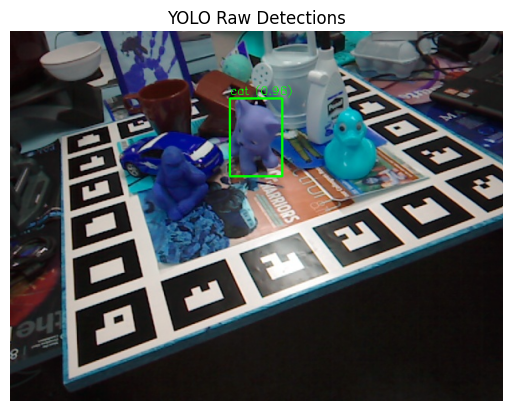


0: 480x640 1 cat, 158.3ms
Speed: 3.0ms preprocess, 158.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
📦 YOLO returned 1 boxes
✅ MATCH! This box will be used.

➡️ Object 6 (mapped ID 0)
ADD: 0.1087 m | Angular Error: 136.19°


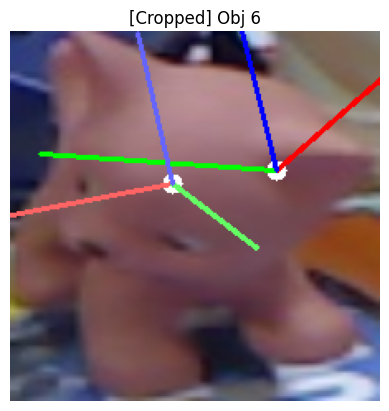

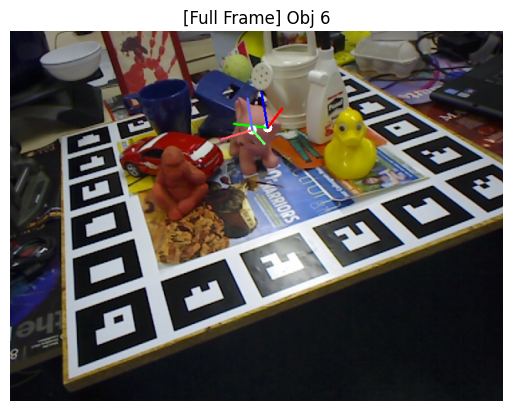

⚠️ Missing YOLO detections for object IDs in image 48: [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [ ]:
from ultralytics import YOLO

print("✅ Object IDs in dataset:", dataset.object_ids)  # original IDs.
all_mapped_ids, _ = dataset.getMappedIDs()
#print("Mapped IDs:", all_mapped_ids)

# --- IDs to visualize ---
original_ids_to_visualize = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

# Load model (make sure num_objects matches the one used during training)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiating PoseNet6D.
pose_model = PoseNet6D(num_objects=13)
pose_model.load_state_dict(torch.load(MyPoseModel,
                                      map_location=device))
pose_model.to(device)

# Instatiating Yolo.
yolo_model = YOLO(MyYoloModel)
yolo_model.to(device)
#print(yolo_model.names)

# --- Set visualization options ---
mapped_ids, _ = dataset.getMappedIDs(original_ids_to_visualize)
#print(mapped_ids)
img_idx = 48

#img_path = os.path.join(dataset_root, "02/rgb/1213.png")

img = dataset[img_idx]['original_rgb']

yolo_results = yolo_model(img)

#yolo_results = yolo_model(source=img_path)

img_copy = np.array(img).copy()
for box in yolo_results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    cls = int(box.cls.item())
    conf = box.conf.item()
    label = f"{yolo_model.names[cls]} ({conf:.2f})"
    cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img_copy, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, (0, 255, 0), 1)

plt.figure()
plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
plt.title("YOLO Raw Detections")
plt.axis("off")
plt.show()

# Camera intrinsics.
cam_K = np.array([[572.4114, 0.0, 325.2611],
                 [0.0, 573.57043, 242.04899],
                 [0.0, 0.0, 1.0]])

# --- Run visualization ---
run_visualization(
    model=pose_model,
    dataset=dataset,
    device=device,
    target_obj_ids=original_ids_to_visualize,
    img_idx=img_idx,
    cam_K=cam_K,
    yolo_model=yolo_model,
    yolo_conf=0.5,
    full_frame=True,
    draw_axes=True,
    draw_legend=False,
    draw_bboxes=False,
    draw_models=False)